In [79]:
#Author: Eren Ali Aslangiray

import librosa
from librosa import display
import time
import os
import pandas as pd
import joblib
import numpy as np

sr=22050

### Author's Notes:

At part 1, I tried to build various models and with using different feature extraction methods to find best data extraction and model to use it on mass model building step. So part 1 is mini version and the exeperimental area of the whole work.

# ----------------------DATA PREPARING----------------------

# 1- RAVDESS DATABASE

## 1.1- Data Extraction

In [24]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file) == "/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/.DS_Store":
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = int(file[7:8]) - 1
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [26]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [33]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 1.2- Data Load

In [115]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y.joblib')

## 1.3- MEAN MFCCs KERAS MODEL (With 8 Emotion Label)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

Using TensorFlow backend.


In [80]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
__________

In [82]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model.h5')
loaded_model.summary()
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## 1.4- MEAN MFCCs KERAS MODEL (With reduced labels. Labels = 4)

In [116]:
#Dont forget to load data from 1.2
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad
#calm became neutral. fearful, disgust, surprised will be removed. 
i = 0
for item in y:
    if item == 1:
        y[i]=0
    i = i+1
i = 0
for item in y:
    if item==4:
        y[i]=1
    i = i +1

lista = list(X)
listb = list(y)
dellist = [5,6,7]

for i in range (len(listb)-1,-1,-1):
    if listb[i] in dellist:
        lista.pop(i)
        listb.pop(i)

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(lista), np.asarray(listb), test_size=0.33, random_state=42)

In [118]:
#DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

In [119]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       378
           1       0.91      0.87      0.89       238
           2       0.85      0.81      0.83       267
           3       0.75      0.82      0.79       243

   micro avg       0.84      0.84      0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126



In [67]:
#Now its time for keras :)

import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

Using TensorFlow backend.


In [68]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [69]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [70]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Train on 2285 samples, validate on 1126 samples
Epoch 1/1000
2285/2285 [==============================] - 1s 570us/step - loss: 4.8675 - acc: 0.2713 - val_loss: 1.4530 - val_acc: 0.3242
Epoch 2/1000
2285/2285 [==============================] - 1s 394us/step - loss: 3.9055 - acc: 0.2893 - val_loss: 2.1263 - val_acc: 0.3650
Epoch 3/1000
2285/2285 [==============================] - 1s 414us/step - loss: 3.2906 - acc: 0.3103 - val_loss: 2.3639 - val_acc: 0.3579
Epoch 4/1000
2285/2285 [==============================] - 1s 434us/step - loss: 2.9058 - acc: 0.3151 - val_loss: 1.4374 - val_acc: 0.4165
Epoch 5/1000
2285/2285 [==============================] - 1s 402us/step - loss: 2.3511 - acc: 0.3554 - val_loss: 1.3819 - val_acc: 0.4503
Epoch 6/1000
2285/2285 [==============================] - 1s 402us/step - loss: 2.1364 - acc: 0.3488 - val_loss: 1.2185 - val_acc: 0.4609
Epoch 7/1000
2285/2285 [==============================] - 1s 404us/step - loss: 1.8759 - acc: 0.3751 - val_loss: 1.1921 - va

2285/2285 [==============================] - 1s 372us/step - loss: 0.7378 - acc: 0.7120 - val_loss: 0.7126 - val_acc: 0.7460
Epoch 60/1000
2285/2285 [==============================] - 1s 524us/step - loss: 0.7221 - acc: 0.7278 - val_loss: 0.7147 - val_acc: 0.7291
Epoch 61/1000
2285/2285 [==============================] - 1s 394us/step - loss: 0.7387 - acc: 0.7042 - val_loss: 0.6994 - val_acc: 0.7336
Epoch 62/1000
2285/2285 [==============================] - 1s 329us/step - loss: 0.7204 - acc: 0.7204 - val_loss: 0.6914 - val_acc: 0.7282
Epoch 63/1000
2285/2285 [==============================] - 1s 353us/step - loss: 0.7213 - acc: 0.7287 - val_loss: 0.6987 - val_acc: 0.7265
Epoch 64/1000
2285/2285 [==============================] - 1s 367us/step - loss: 0.7035 - acc: 0.7304 - val_loss: 0.6862 - val_acc: 0.7300
Epoch 65/1000
2285/2285 [==============================] - 1s 479us/step - loss: 0.6973 - acc: 0.7344 - val_loss: 0.6964 - val_acc: 0.7496
Epoch 66/1000
2285/2285 [================

Epoch 118/1000
2285/2285 [==============================] - 1s 475us/step - loss: 0.5299 - acc: 0.7982 - val_loss: 0.5385 - val_acc: 0.7895
Epoch 119/1000
2285/2285 [==============================] - 1s 505us/step - loss: 0.5190 - acc: 0.8057 - val_loss: 0.5426 - val_acc: 0.7895
Epoch 120/1000
2285/2285 [==============================] - 1s 557us/step - loss: 0.5231 - acc: 0.7939 - val_loss: 0.5574 - val_acc: 0.7753
Epoch 121/1000
2285/2285 [==============================] - 1s 636us/step - loss: 0.5325 - acc: 0.7891 - val_loss: 0.5524 - val_acc: 0.7895
Epoch 122/1000
2285/2285 [==============================] - 1s 585us/step - loss: 0.5237 - acc: 0.7956 - val_loss: 0.5402 - val_acc: 0.7886
Epoch 123/1000
2285/2285 [==============================] - 1s 553us/step - loss: 0.5109 - acc: 0.7956 - val_loss: 0.5399 - val_acc: 0.7753
Epoch 124/1000
2285/2285 [==============================] - 1s 561us/step - loss: 0.5249 - acc: 0.7961 - val_loss: 0.5403 - val_acc: 0.7913
Epoch 125/1000
2285/

2285/2285 [==============================] - 1s 628us/step - loss: 0.4097 - acc: 0.8446 - val_loss: 0.4431 - val_acc: 0.8215
Epoch 177/1000
2285/2285 [==============================] - 1s 559us/step - loss: 0.4161 - acc: 0.8468 - val_loss: 0.4620 - val_acc: 0.8197
Epoch 178/1000
2285/2285 [==============================] - 1s 448us/step - loss: 0.3965 - acc: 0.8468 - val_loss: 0.4496 - val_acc: 0.8099
Epoch 179/1000
2285/2285 [==============================] - 1s 401us/step - loss: 0.4095 - acc: 0.8438 - val_loss: 0.4454 - val_acc: 0.8286
Epoch 180/1000
2285/2285 [==============================] - 1s 459us/step - loss: 0.4194 - acc: 0.8363 - val_loss: 0.4560 - val_acc: 0.8153
Epoch 181/1000
2285/2285 [==============================] - 1s 451us/step - loss: 0.4093 - acc: 0.8473 - val_loss: 0.4584 - val_acc: 0.8037
Epoch 182/1000
2285/2285 [==============================] - 1s 627us/step - loss: 0.4016 - acc: 0.8407 - val_loss: 0.4422 - val_acc: 0.8242
Epoch 183/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 494us/step - loss: 0.3312 - acc: 0.8788 - val_loss: 0.3830 - val_acc: 0.8446
Epoch 235/1000
2285/2285 [==============================] - 1s 375us/step - loss: 0.3230 - acc: 0.8832 - val_loss: 0.3908 - val_acc: 0.8339
Epoch 236/1000
2285/2285 [==============================] - 1s 431us/step - loss: 0.3287 - acc: 0.8761 - val_loss: 0.3975 - val_acc: 0.8224
Epoch 237/1000
2285/2285 [==============================] - 1s 393us/step - loss: 0.3246 - acc: 0.8832 - val_loss: 0.3774 - val_acc: 0.8437
Epoch 238/1000
2285/2285 [==============================] - 1s 381us/step - loss: 0.3121 - acc: 0.8827 - val_loss: 0.3852 - val_acc: 0.8384
Epoch 239/1000
2285/2285 [==============================] - 1s 383us/step - loss: 0.3295 - acc: 0.8713 - val_loss: 0.3976 - val_acc: 0.8286
Epoch 240/1000
2285/2285 [==============================] - 1s 373us/step - loss: 0.3325 - acc: 0.8779 - val_loss: 0.3617 - val_acc: 0.8455
Epoch 241/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 448us/step - loss: 0.2584 - acc: 0.9050 - val_loss: 0.3214 - val_acc: 0.8739
Epoch 293/1000
2285/2285 [==============================] - 1s 439us/step - loss: 0.2516 - acc: 0.9107 - val_loss: 0.3540 - val_acc: 0.8561
Epoch 294/1000
2285/2285 [==============================] - 1s 429us/step - loss: 0.2711 - acc: 0.9068 - val_loss: 0.3371 - val_acc: 0.8508
Epoch 295/1000
2285/2285 [==============================] - 1s 430us/step - loss: 0.2596 - acc: 0.9103 - val_loss: 0.3232 - val_acc: 0.8819
Epoch 296/1000
2285/2285 [==============================] - 1s 433us/step - loss: 0.2672 - acc: 0.9007 - val_loss: 0.3367 - val_acc: 0.8757
Epoch 297/1000
2285/2285 [==============================] - 1s 437us/step - loss: 0.2631 - acc: 0.9002 - val_loss: 0.3219 - val_acc: 0.8783
Epoch 298/1000
2285/2285 [==============================] - 1s 441us/step - loss: 0.2625 - acc: 0.8950 - val_loss: 0.3188 - val_acc: 0.8837
Epoch 299/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 446us/step - loss: 0.2245 - acc: 0.9212 - val_loss: 0.2935 - val_acc: 0.8837
Epoch 351/1000
2285/2285 [==============================] - 1s 432us/step - loss: 0.2002 - acc: 0.9317 - val_loss: 0.2953 - val_acc: 0.8854
Epoch 352/1000
2285/2285 [==============================] - 1s 436us/step - loss: 0.2143 - acc: 0.9234 - val_loss: 0.2952 - val_acc: 0.8872
Epoch 353/1000
2285/2285 [==============================] - 1s 440us/step - loss: 0.2294 - acc: 0.9116 - val_loss: 0.3056 - val_acc: 0.8881
Epoch 354/1000
2285/2285 [==============================] - 1s 426us/step - loss: 0.2135 - acc: 0.9186 - val_loss: 0.2944 - val_acc: 0.8899
Epoch 355/1000
2285/2285 [==============================] - 1s 447us/step - loss: 0.2103 - acc: 0.9309 - val_loss: 0.2956 - val_acc: 0.8881
Epoch 356/1000
2285/2285 [==============================] - 1s 430us/step - loss: 0.2134 - acc: 0.9274 - val_loss: 0.2851 - val_acc: 0.8890
Epoch 357/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 429us/step - loss: 0.1766 - acc: 0.9344 - val_loss: 0.2418 - val_acc: 0.9085
Epoch 409/1000
2285/2285 [==============================] - 1s 429us/step - loss: 0.1722 - acc: 0.9383 - val_loss: 0.2943 - val_acc: 0.8925
Epoch 410/1000
2285/2285 [==============================] - 1s 430us/step - loss: 0.1794 - acc: 0.9396 - val_loss: 0.2400 - val_acc: 0.9103
Epoch 411/1000
2285/2285 [==============================] - 1s 429us/step - loss: 0.1793 - acc: 0.9374 - val_loss: 0.2524 - val_acc: 0.9023
Epoch 412/1000
2285/2285 [==============================] - 1s 445us/step - loss: 0.1743 - acc: 0.9374 - val_loss: 0.2474 - val_acc: 0.9112
Epoch 413/1000
2285/2285 [==============================] - 1s 428us/step - loss: 0.1730 - acc: 0.9405 - val_loss: 0.2522 - val_acc: 0.9094
Epoch 414/1000
2285/2285 [==============================] - 1s 435us/step - loss: 0.1733 - acc: 0.9370 - val_loss: 0.2431 - val_acc: 0.9112
Epoch 415/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 492us/step - loss: 0.1455 - acc: 0.9519 - val_loss: 0.2500 - val_acc: 0.9076
Epoch 467/1000
2285/2285 [==============================] - 1s 513us/step - loss: 0.1508 - acc: 0.9488 - val_loss: 0.2266 - val_acc: 0.9156
Epoch 468/1000
2285/2285 [==============================] - 1s 442us/step - loss: 0.1409 - acc: 0.9514 - val_loss: 0.2731 - val_acc: 0.9094
Epoch 469/1000
2285/2285 [==============================] - 1s 438us/step - loss: 0.1442 - acc: 0.9484 - val_loss: 0.2177 - val_acc: 0.9298
Epoch 470/1000
2285/2285 [==============================] - 1s 411us/step - loss: 0.1465 - acc: 0.9470 - val_loss: 0.2265 - val_acc: 0.9156
Epoch 471/1000
2285/2285 [==============================] - 1s 430us/step - loss: 0.1447 - acc: 0.9510 - val_loss: 0.2062 - val_acc: 0.9316
Epoch 472/1000
2285/2285 [==============================] - 1s 393us/step - loss: 0.1402 - acc: 0.9523 - val_loss: 0.2074 - val_acc: 0.9245
Epoch 473/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 413us/step - loss: 0.1282 - acc: 0.9484 - val_loss: 0.1925 - val_acc: 0.9369
Epoch 525/1000
2285/2285 [==============================] - 1s 403us/step - loss: 0.1224 - acc: 0.9536 - val_loss: 0.1944 - val_acc: 0.9307
Epoch 526/1000
2285/2285 [==============================] - 1s 393us/step - loss: 0.1203 - acc: 0.9611 - val_loss: 0.2037 - val_acc: 0.9192
Epoch 527/1000
2285/2285 [==============================] - 1s 439us/step - loss: 0.1262 - acc: 0.9584 - val_loss: 0.1983 - val_acc: 0.9281
Epoch 528/1000
2285/2285 [==============================] - 1s 419us/step - loss: 0.1277 - acc: 0.9589 - val_loss: 0.1984 - val_acc: 0.9334
Epoch 529/1000
2285/2285 [==============================] - 1s 419us/step - loss: 0.1193 - acc: 0.9597 - val_loss: 0.2175 - val_acc: 0.9325
Epoch 530/1000
2285/2285 [==============================] - 1s 408us/step - loss: 0.1289 - acc: 0.9540 - val_loss: 0.1983 - val_acc: 0.9334
Epoch 531/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 654us/step - loss: 0.1062 - acc: 0.9632 - val_loss: 0.1893 - val_acc: 0.9396
Epoch 583/1000
2285/2285 [==============================] - 2s 698us/step - loss: 0.1036 - acc: 0.9637 - val_loss: 0.2080 - val_acc: 0.9263
Epoch 584/1000
2285/2285 [==============================] - 1s 580us/step - loss: 0.1020 - acc: 0.9689 - val_loss: 0.1798 - val_acc: 0.9485
Epoch 585/1000
2285/2285 [==============================] - 1s 596us/step - loss: 0.0896 - acc: 0.9702 - val_loss: 0.1782 - val_acc: 0.9458
Epoch 586/1000
2285/2285 [==============================] - 1s 522us/step - loss: 0.1008 - acc: 0.9707 - val_loss: 0.1913 - val_acc: 0.9334
Epoch 587/1000
2285/2285 [==============================] - 1s 594us/step - loss: 0.0990 - acc: 0.9676 - val_loss: 0.2065 - val_acc: 0.9334
Epoch 588/1000
2285/2285 [==============================] - 1s 563us/step - loss: 0.1029 - acc: 0.9646 - val_loss: 0.1982 - val_acc: 0.9378
Epoch 589/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 387us/step - loss: 0.0887 - acc: 0.9720 - val_loss: 0.1866 - val_acc: 0.9440
Epoch 641/1000
2285/2285 [==============================] - 1s 352us/step - loss: 0.0836 - acc: 0.9724 - val_loss: 0.1667 - val_acc: 0.9494
Epoch 642/1000
2285/2285 [==============================] - 1s 408us/step - loss: 0.0881 - acc: 0.9698 - val_loss: 0.1696 - val_acc: 0.9476
Epoch 643/1000
2285/2285 [==============================] - 1s 379us/step - loss: 0.0862 - acc: 0.9689 - val_loss: 0.1610 - val_acc: 0.9458
Epoch 644/1000
2285/2285 [==============================] - 1s 347us/step - loss: 0.0938 - acc: 0.9681 - val_loss: 0.1710 - val_acc: 0.9449
Epoch 645/1000
2285/2285 [==============================] - 1s 476us/step - loss: 0.0807 - acc: 0.9720 - val_loss: 0.1674 - val_acc: 0.9467
Epoch 646/1000
2285/2285 [==============================] - 2s 754us/step - loss: 0.0847 - acc: 0.9751 - val_loss: 0.1754 - val_acc: 0.9369
Epoch 647/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 312us/step - loss: 0.0789 - acc: 0.9729 - val_loss: 0.1630 - val_acc: 0.9494
Epoch 699/1000
2285/2285 [==============================] - 1s 316us/step - loss: 0.0807 - acc: 0.9720 - val_loss: 0.1933 - val_acc: 0.9254
Epoch 700/1000
2285/2285 [==============================] - 1s 313us/step - loss: 0.0823 - acc: 0.9737 - val_loss: 0.1680 - val_acc: 0.9440
Epoch 701/1000
2285/2285 [==============================] - 1s 315us/step - loss: 0.0819 - acc: 0.9755 - val_loss: 0.1976 - val_acc: 0.9254
Epoch 702/1000
2285/2285 [==============================] - 1s 356us/step - loss: 0.0794 - acc: 0.9751 - val_loss: 0.1625 - val_acc: 0.9440
Epoch 703/1000
2285/2285 [==============================] - 1s 352us/step - loss: 0.0843 - acc: 0.9702 - val_loss: 0.1774 - val_acc: 0.9423
Epoch 704/1000
2285/2285 [==============================] - 1s 327us/step - loss: 0.0719 - acc: 0.9777 - val_loss: 0.1611 - val_acc: 0.9485
Epoch 705/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 411us/step - loss: 0.0738 - acc: 0.9772 - val_loss: 0.1594 - val_acc: 0.9467
Epoch 757/1000
2285/2285 [==============================] - 1s 462us/step - loss: 0.0670 - acc: 0.9803 - val_loss: 0.1441 - val_acc: 0.9512
Epoch 758/1000
2285/2285 [==============================] - 1s 408us/step - loss: 0.0670 - acc: 0.9755 - val_loss: 0.1703 - val_acc: 0.9440
Epoch 759/1000
2285/2285 [==============================] - 1s 401us/step - loss: 0.0747 - acc: 0.9737 - val_loss: 0.1898 - val_acc: 0.9325
Epoch 760/1000
2285/2285 [==============================] - 1s 400us/step - loss: 0.0619 - acc: 0.9816 - val_loss: 0.1654 - val_acc: 0.9467
Epoch 761/1000
2285/2285 [==============================] - 1s 400us/step - loss: 0.0651 - acc: 0.9803 - val_loss: 0.1512 - val_acc: 0.9529
Epoch 762/1000
2285/2285 [==============================] - 1s 447us/step - loss: 0.0684 - acc: 0.9772 - val_loss: 0.1457 - val_acc: 0.9485
Epoch 763/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 419us/step - loss: 0.0613 - acc: 0.9812 - val_loss: 0.1695 - val_acc: 0.9440
Epoch 815/1000
2285/2285 [==============================] - 1s 401us/step - loss: 0.0763 - acc: 0.9786 - val_loss: 0.1577 - val_acc: 0.9503
Epoch 816/1000
2285/2285 [==============================] - 1s 404us/step - loss: 0.0639 - acc: 0.9790 - val_loss: 0.1652 - val_acc: 0.9494
Epoch 817/1000
2285/2285 [==============================] - 1s 405us/step - loss: 0.0655 - acc: 0.9772 - val_loss: 0.1589 - val_acc: 0.9467
Epoch 818/1000
2285/2285 [==============================] - 1s 399us/step - loss: 0.0710 - acc: 0.9781 - val_loss: 0.1465 - val_acc: 0.9520
Epoch 819/1000
2285/2285 [==============================] - 1s 411us/step - loss: 0.0644 - acc: 0.9816 - val_loss: 0.1648 - val_acc: 0.9494
Epoch 820/1000
2285/2285 [==============================] - 1s 399us/step - loss: 0.0609 - acc: 0.9790 - val_loss: 0.1518 - val_acc: 0.9494
Epoch 821/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 393us/step - loss: 0.0599 - acc: 0.9799 - val_loss: 0.1522 - val_acc: 0.9565
Epoch 873/1000
2285/2285 [==============================] - 1s 395us/step - loss: 0.0596 - acc: 0.9821 - val_loss: 0.1649 - val_acc: 0.9467
Epoch 874/1000
2285/2285 [==============================] - 1s 400us/step - loss: 0.0581 - acc: 0.9851 - val_loss: 0.1658 - val_acc: 0.9352
Epoch 875/1000
2285/2285 [==============================] - 1s 406us/step - loss: 0.0533 - acc: 0.9786 - val_loss: 0.1408 - val_acc: 0.9538
Epoch 876/1000
2285/2285 [==============================] - 1s 406us/step - loss: 0.0538 - acc: 0.9816 - val_loss: 0.1587 - val_acc: 0.9467
Epoch 877/1000
2285/2285 [==============================] - 1s 398us/step - loss: 0.0520 - acc: 0.9829 - val_loss: 0.1521 - val_acc: 0.9538
Epoch 878/1000
2285/2285 [==============================] - 1s 405us/step - loss: 0.0555 - acc: 0.9838 - val_loss: 0.1536 - val_acc: 0.9503
Epoch 879/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 628us/step - loss: 0.0462 - acc: 0.9847 - val_loss: 0.1417 - val_acc: 0.9529
Epoch 931/1000
2285/2285 [==============================] - 1s 378us/step - loss: 0.0671 - acc: 0.9777 - val_loss: 0.1581 - val_acc: 0.9520
Epoch 932/1000
2285/2285 [==============================] - 1s 623us/step - loss: 0.0448 - acc: 0.9873 - val_loss: 0.1528 - val_acc: 0.9494
Epoch 933/1000
2285/2285 [==============================] - 1s 592us/step - loss: 0.0554 - acc: 0.9777 - val_loss: 0.1486 - val_acc: 0.9512
Epoch 934/1000
2285/2285 [==============================] - 1s 592us/step - loss: 0.0421 - acc: 0.9856 - val_loss: 0.1750 - val_acc: 0.9449
Epoch 935/1000
2285/2285 [==============================] - 1s 575us/step - loss: 0.0485 - acc: 0.9829 - val_loss: 0.1641 - val_acc: 0.9494
Epoch 936/1000
2285/2285 [==============================] - 1s 571us/step - loss: 0.0433 - acc: 0.9869 - val_loss: 0.1562 - val_acc: 0.9476
Epoch 937/1000
2285/2285 [=========

2285/2285 [==============================] - 1s 410us/step - loss: 0.0297 - acc: 0.9926 - val_loss: 0.1627 - val_acc: 0.9556
Epoch 989/1000
2285/2285 [==============================] - 1s 406us/step - loss: 0.0424 - acc: 0.9882 - val_loss: 0.1531 - val_acc: 0.9556
Epoch 990/1000
2285/2285 [==============================] - 1s 407us/step - loss: 0.0483 - acc: 0.9864 - val_loss: 0.1632 - val_acc: 0.9512
Epoch 991/1000
2285/2285 [==============================] - 1s 408us/step - loss: 0.0557 - acc: 0.9821 - val_loss: 0.1462 - val_acc: 0.9512
Epoch 992/1000
2285/2285 [==============================] - 1s 408us/step - loss: 0.0371 - acc: 0.9882 - val_loss: 0.1500 - val_acc: 0.9547
Epoch 993/1000
2285/2285 [==============================] - 1s 417us/step - loss: 0.0392 - acc: 0.9882 - val_loss: 0.1588 - val_acc: 0.9485
Epoch 994/1000
2285/2285 [==============================] - 1s 405us/step - loss: 0.0395 - acc: 0.9873 - val_loss: 0.1594 - val_acc: 0.9467
Epoch 995/1000
2285/2285 [=========

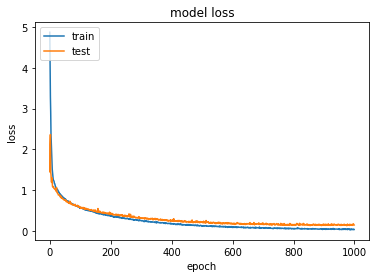

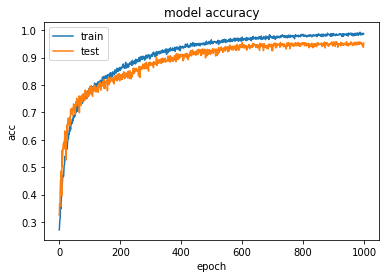

In [71]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       378
           1       0.96      0.92      0.94       238
           2       0.95      0.94      0.94       267
           3       0.94      0.96      0.95       243

   micro avg       0.95      0.95      0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



In [74]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad

[[371   0   3   4]
 [  5 219  10   4]
 [  4   7 250   6]
 [  8   2   0 233]]


In [75]:
model_name = 'Emotion_Voice_Detection_Model_Reduced_Labels.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_Reduced_Labels.h5 


In [78]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_Reduced_Labels.h5')
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1126/1126 [==============================] - 0s 173us/step
Restored model, accuracy: 95.29%


## 1.5- MEAN DB AMPLITUDE MODEL AND .T VERSION (Soruce Data - LESS Data)

In [101]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X_wave.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y_wave.joblib')

In [102]:
X_db = []
for item in X:
    S = librosa.feature.melspectrogram(y=item, sr=sr)
    k = np.mean(librosa.amplitude_to_db(S, ref=np.max).T,axis=0)
    X_db.append(k)
    
print (len(X_db))

1440


In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X_db), y, test_size=0.33, random_state=42)

In [92]:
#DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

In [93]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.29      0.34      0.31        32
           1       0.53      0.49      0.51        59
           2       0.24      0.21      0.22        67
           3       0.24      0.22      0.23        59
           4       0.25      0.22      0.23        68
           5       0.26      0.28      0.27        61
           6       0.30      0.33      0.31        64
           7       0.33      0.36      0.35        66

   micro avg       0.30      0.30      0.30       476
   macro avg       0.30      0.31      0.30       476
weighted avg       0.30      0.30      0.30       476



# 2- SAVEE DATABASE

## 2.1- Data Extraction

In [14]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/1'
lst = []
numlist = ["0","1","2","3","4","5","6","7","8","9"]

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[0:2]
        if file[1] in numlist:
            file = file[0]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [16]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"a":4,"d":6,"f":5,"h":2 ,"n":0 ,"sa":3 ,"su":7}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [26]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 2.2- Data Load

In [29]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/y.joblib')
y = np.asarray(y)

# 3- GERMAN DATABASE

## 3.1- Data Extraction

In [34]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/wav'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[5]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [36]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [39]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"W":4,"L":1,"E":6,"A":5 ,"F":2 ,"T":3,"N":0}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [41]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 3.2- Data Load

In [42]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/y.joblib')
y = np.asarray(y)

# 4- TESS DATABASE

## 4.1- Data Extraction

### 4.1.1- Web Crawling (Database items are available at different links)

In [3]:
import os, ssl
from bs4 import BeautifulSoup
import urllib.request
import re
import shutil
import requests
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
starturl = "https://tspace.library.utoronto.ca/handle/1807/24501"
initbaseurl = "https://tspace.library.utoronto.ca/handle/1807/"
baseurl = "https://tspace.library.utoronto.ca"
urllist = []
x = int(starturl[-5:])
while x > 24487:
    urllist.append(initbaseurl + str(x))
    x = x-1

In [5]:
data_urls = []

for item in urllist:
    r = requests.get(item)
    data = r.text
    soup = BeautifulSoup(data)
    for link in soup.find_all('a'):
        if link.get('href').endswith(".wav"):
            data_urls.append(link.get('href'))

In [10]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neurtal":0 ,"happy":2 ,"disgust":6 ,"sad":3}
labellist = ["ps.wav","angry.wav","fear.wav","neutral.wav","happy.wav","disgust.wav","sad.wav"]

In [ ]:
output_file_path = "/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/"
i = 0
for data in data_urls:
    for item in labellist:
        if item in data:
            url = baseurl + data
            output_file = output_file_path+str(i)+"_"+ item
            with urllib.request.urlopen(url) as response, open(output_file, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
            i = i+1

### 4.1.2- Data Extraction & Saving

In [30]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database'
lst = []
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neutral":0 ,"happy":2 ,"disgust":6 ,"sad":3}

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        for item in label_to_num:
            if item in str(file):
                file = label_to_num[item]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [32]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [36]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 4.2- Data Load

In [42]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/y.joblib')
y = np.asarray(y)

# ----------------------MASS MODEL BUILDING----------------------

# 1- Data Preparing

### 1.1- Gathering All The Datasets Together

In [50]:
#bla bla bla

### 1.2- Saving The Big Dataset

In [51]:
#bla bla bla

### 1.3- Feature Extraction

In [52]:
#bla bla bla

# 2- Model Building

### 2.1- MEAN MFCCs KERAS MODEL (/W using RAVDESS big data and other databases.)

In [54]:
#bla bla bla

### 2.2- MEAN MFCCs REDUCED KERAS MODEL (/W using RAVDESS big data and other databases.) (4 LABEL)

In [55]:
#bla bla bla

### 2.3- MEAN DB AMPLITUDE MODEL AND .T VERSION (/W using RAVDESS small data and other databases)

In [56]:
#bla bla bla

### 2.4- WAVELET DATA EXPLORATION & MODEL BUILDING

In [57]:
#bla bla bla

### 2.5- SAVING MODELS

In [58]:
#bla bla bla

# 3- Model Testing & Evaluating 

In [59]:
#bla bla bla